# Assignment 2: Text Classification with Deep Averaged Networks

**Description:** This assignment covers various neural network architectures and components, largely used in the context of classification. You will compare Deep Averaging Networks, Deep Weighted Averaging Networks using Attention, and BERT-based models. In part one, you should be able to develop an intuition for:


*   The effects of fine-tuning word vectors or starting with random word vectors
*   How various networks behave when the training set size changes
*   The effect of shuffling your training data
*   The effect of fine tuning your embeddings



The assignment notebook closely follows the lesson notebooks. We will use the IMDB dataset and will leverage some of the models, or part of the code, for our current investigation.

This notebook uses the Keras 3 functional API.  Make sure the correct versions get loaded.







## IMPORTANT NOTE:
Because of the environment built in to Colab, the software we're importing causes an error to be thrown the first time you run the cells in the Setup section.  As soon as you hit the error, you have to go to the Runtime menu and select 'Restart Session'.  Once the session is restarted you must rerun the cells in Setup and you will not run in to the error.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2025-fall-main/blob/master/assignment/a2/Text_classification_DAN.ipynb)

The overall assignment structure is as follows:


0. Setup
  
  0.1 Libraries, Embeddings,  & Helper Functions

  0.2 Data Acquisition

  0.3. Data Preparation

    0.3.1 Training/Test Sets using Word2Vec

    0.3.2 Training/Test Sets for BERT-based models


1. Classification with various Word2Vec-based Models

  1.1 The Role of Shuffling of the Training Set

  1.2 DAN
    
  1.3 Approaches for Training of Embeddings



**INSTRUCTIONS:**:

* Questions are always indicated as **QUESTION**, so you can search for this string to make sure you answered all of the questions. You are expected to fill out, run, and submit this notebook, as well as to answer the questions in the **answers** file as you did in a1.  Please do **not** remove the output from your notebooks when you submit them as we'll look at the output as well as your code for grading purposes.  We cannot award points if the output cells are empty.

* **### YOUR CODE HERE** indicates that you are supposed to write code.

* If you want to, you can run all of the cells in section 0 in bulk. This is setup work and no questions are in there. At the end of section 0 we will state all of the relevant variables that were defined and created in section 1.

* Finally, unless otherwise indicated your validation accuracy will be 0.65 or higher if you have correctly implemented the model.

## 0. Setup

### 0.1. Libraries and Helper Functions

This notebook requires the TensorFlow dataset and other prerequisites that you must download.  THis model uses the Keras 3 interface.

In [ ]:
# #@title Installation, if using colab
# # Install uv, the fast package manager
# !pip install uv --quiet
# !uv pip install pydot gensim tensorflow-datasets tensorflow-text --quiet

# # This command forces the session to restart.
# # Run this cell after your installations.
# import os
# os.kill(os.getpid(), 9)

Now we are ready to do the imports.

In [ ]:
#@title Imports
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

from keras.layers import Embedding, Input, Dense, Lambda
from keras.models import Model

import tensorflow_datasets as tfds
import tensorflow_text as tf_text


import sklearn as sk

import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

2025-09-25 13:58:35.599461: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-25 13:58:36.412483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758833916.677451 1859969 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758833916.749254 1859969 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758833917.135330 1859969 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Make sure you are using a Keras version > 3.0 and a tensorflow version > 2.16.0 for this notebook.

Below is a helper function to plot histories.

In [2]:
#@title Plotting Function

# 4-window plot. Small modification from matplotlib examples.
def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    """
    Compare training histories of two models by plotting loss and accuracy.

    Parameters
    ----------
    axs : numpy.ndarray of matplotlib.axes.Axes
        2x2 grid of Axes objects (rows = metrics, cols = models).
    model_history1 : keras.callbacks.History
        Training history object for the first model.
    model_history2 : keras.callbacks.History
        Training history object for the second model.
    model_1_name : str
        Display name for the first model (default: 'model 1').
    model_2_name : str
        Display name for the second model (default: 'model 2').

    Notes
    -----
    - This function assumes `axs` is a 2D array where:
        axs[0,0] = loss for model 1, axs[0,1] = loss for model 2
        axs[1,0] = accuracy for model 1, axs[1,1] = accuracy for model 2
    - It will plot both training and validation curves for each metric.
    """

    # Create a box style for axis labels
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    # Iterate over metrics to plot: 'loss' and 'accuracy'
    for i, metric in enumerate(['loss', 'accuracy']):

        # Some models (e.g., Weighted Averaging with Attention) store metrics under different keys
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        # Calculate lower y-limit: minimum value across both models, scaled down a bit
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        # Calculate upper y-limit: maximum value across both models, scaled up a bit
        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        # Iterate over both models for this metric
        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]  # pick proper model name
            model_metric = [metric, metric2][j]           # pick proper metric key

            # Select correct subplot
            ax1 = axs[i, j]

            # Plot training history
            ax1.plot(model_history.history[model_metric], label='train')
            # Plot validation history
            ax1.plot(model_history.history['val_%s' % model_metric], label='val')

            # Title: metric + model name
            ax1.set_title('%s - %s' % (metric, model_name))

            # Label y-axis with a styled box
            ax1.set_ylabel(metric, bbox=box)

            # Keep y-limits consistent between both models for fair comparison
            ax1.set_ylim(y_lim_lower, y_lim_upper)

            # Add legend for clarity
            ax1.legend()


Next, we get the word2vec model from NLTK to use as our embeddings.

In [3]:
#@title NLTK & Word2Vec

nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

wvmodel = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /data/homezvol2/ddlin/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


Now here we have the embedding **model** defined, let's see how many words are in the vocabulary:

In [4]:
len(wvmodel)

43981

What do the word vectors look like? As expected:

In [ ]:
# Ok wvmodel is the dictionary-like object containing word as key and their embeddings as values
wvmodel['great'][:20]

array([ 0.0306035 ,  0.0886877 , -0.0121269 ,  0.0761965 ,  0.0566269 ,
       -0.0424702 ,  0.0410129 , -0.0497567 , -0.00364328,  0.0632889 ,
       -0.0142608 , -0.0791111 ,  0.0174877 , -0.0383064 ,  0.00926433,
        0.0295626 ,  0.0770293 ,  0.0949334 , -0.0428866 , -0.0295626 ],
      dtype=float32)

In [ ]:
# This gets you all the keys
wvmodel.index_to_key[:3]

['fawn', 'deferment', 'Debts']

We can now build the embedding matrix and a vocabulary dictionary:

In [ ]:
EMBEDDING_DIM = len(wvmodel['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map, with an extra row for unknown tokens
embedding_matrix = np.zeros((len(wvmodel) + 1, EMBEDDING_DIM))

# vacab dict will have word as key and their index in the embedding matrix as value
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(wvmodel.index_to_key):
    # The the embedding vector for the word
    embedding_vector = wvmodel[word]

    if embedding_vector is not None:

        # Construct the embedding matrix, words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

        # construct the vocab dict for index lookup
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [7]:
embedding_matrix.shape

(43982, 300)

In [ ]:
# Looks like it's ready to go for the TF
embedding_matrix[:5, :5]

array([[ 0.0891758 ,  0.121832  , -0.0671959 ,  0.0477279 , -0.013659  ],
       [ 0.0526281 ,  0.013157  , -0.010104  ,  0.0540819 ,  0.0386715 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 ,  0.0347375 ,  0.0288273 ],
       [-0.00157585, -0.0564239 ,  0.00320281,  0.0422498 ,  0.15264399],
       [ 0.0356899 , -0.00367283, -0.065534  ,  0.0213832 ,  0.00788408]])

The last row consists of all zeros. We will use that for the UNK token, the placeholder token for unknown words.

### 0.2 Data Acquisition


We will use the IMDB dataset delivered as part of the TensorFlow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [36]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
# ------------------------------------------------------------------
# 1) Load IMDB with TFDS
#    - as_supervised=True returns (text_tensor, label_tensor) pairs
#    - 'train[:80%]'  -> first 20,000 of the 25,000 train examples
#    - 'test[80%:]'   -> last 5,000 of the 25,000 test examples
# ------------------------------------------------------------------
train_data, test_data = tfds.load(
    name="imdb_reviews",
    split=("train[:80%]", "test[80%:]"),
    as_supervised=True
)

# Optional: shuffle before batching (useful if you plan to sample)
# train_data = train_data.shuffle(20000, reshuffle_each_iteration=False)
# test_data  = test_data.shuffle(5000, reshuffle_each_iteration=False)

# ------------------------------------------------------------------
# 2) Materialize the entire split into a single batch
#    - .batch(N) groups N elements into one tensor
#    - next(iter(...)) fetches that single batch
#    WARNING: This pulls everything into memory at once.
# ------------------------------------------------------------------
train_examples, train_labels = next(iter(train_data.batch(20000)))
test_examples,  test_labels  = next(iter(test_data.batch(5000)))

# ------------------------------------------------------------------
# 3) Inspect shapes/dtypes (sanity check)
# ------------------------------------------------------------------
print("train_examples:", train_examples.shape, train_examples.dtype)  # (20000,) string
print("train_labels:  ", train_labels.shape,  train_labels.dtype)     # (20000,) int64
print("test_examples: ", test_examples.shape,  test_examples.dtype)   # (5000,) string
print("test_labels:   ", test_labels.shape,   test_labels.dtype)      # (5000,) int64

I0000 00:00:1758834486.154439 1859969 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22393 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:e3:00.0, compute capability: 8.0
2025-09-25 14:08:06.812663: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


train_examples: (20000,) <dtype: 'string'>
train_labels:   (20000,) <dtype: 'int64'>
test_examples:  (5000,) <dtype: 'string'>
test_labels:    (5000,) <dtype: 'int64'>


It is always highly recommended to look at the data. What do the records look like? Are they clean or do they contain a lot of cruft (potential noise)?

In [11]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [12]:
# Ok I think it's a review classification problem for positive sentiments
train_labels[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 1])>

For convenience, in this assignment we will define a sequence length and truncate all records at that length. For records that are shorter than our defined sequence length we will add padding characters to insure that our input shapes are consistent across all records.

In [ ]:
# Setting this as global variable
MAX_SEQUENCE_LENGTH = 100

## 0.3. Data Preparation

### 0.3.1. Training/Test Sets for Word2Vec-based Models

First, we tokenize the data:

In [13]:
# WhitespaceTokenizer() → splits text wherever it sees whitespace (' ', \n, \t).
# tokenize(train_examples) → applies this to each review in train_examples.
# Each review becomes a 1-D tensor of tokens (words, punctuation stuck to words, contractions, etc.).
# So train_tokens[0] shows the tokens for the first review in train_examples.

tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(test_examples)

Let's look at some tokens.  Do they look acceptable?

In [14]:
train_tokens[0]

<tf.Tensor: shape=(116,), dtype=string, numpy=
array([b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.',
       b"Don't", b'be', b'lured', b'in', b'by', b'Christopher', b'Walken',
       b'or', b'Michael', b'Ironside.', b'Both', b'are', b'great',
       b'actors,', b'but', b'this', b'must', b'simply', b'be', b'their',
       b'worst', b'role', b'in', b'history.', b'Even', b'their', b'great',
       b'acting', b'could', b'not', b'redeem', b'this', b"movie's",
       b'ridiculous', b'storyline.', b'This', b'movie', b'is', b'an',
       b'early', b'nineties', b'US', b'propaganda', b'piece.', b'The',
       b'most', b'pathetic', b'scenes', b'were', b'those', b'when',
       b'the', b'Columbian', b'rebels', b'were', b'making', b'their',
       b'cases', b'for', b'revolutions.', b'Maria', b'Conchita',
       b'Alonso', b'appeared', b'phony,', b'and', b'her', b'pseudo-love',
       b'affair', b'with', b'Walken', b'was', b'nothing', b'but', b'a',
       b'pathetic', b'emotional', b

Yup... looks right. Of course we will need to take care of the encoding later.

Next, we define a simple function that converts the tokens above into the appropriate word2vec index values so we can retrieve the embedding vector associated with the word.   

In [41]:
def docs_to_vocab_ids(
        tokenized_texts_list,
        vocab_dict, # passing it in to be more explicit
        MAX_SEQUENCE_LENGTH, # passing it in to be more explicit
):
    """
    Convert a collection of tokenized documents into fixed-length
    sequences of integer vocab IDs.

    Parameters
    ----------
    tokenized_texts_list : list of tf.Tensor
        Each element is a tokenized document, represented as a
        Tensor of tokens in byte-string format (dtype=string).
        Example: [b'This', b'is', b'a', b'movie', b'.'].
    vocab_dict : dict
        A dictionary mapping word strings to integer IDs. Must also
        contain a special '[UNK]' token for unknown or padding values.
    MAX_SEQUENCE_LENGTH : int
        Maximum number of tokens to keep per document. Longer documents
        are truncated, shorter documents are padded with '[UNK]' IDs.

    Returns
    -------
    np.ndarray
        2D NumPy array of shape (num_docs, MAX_SEQUENCE_LENGTH), where
        each row is the integer ID sequence corresponding to one document.
        All rows have equal length due to truncation/padding.
    """
    texts_vocab_ids = []   # list to collect all documents as ID sequences

    for i, token_list in enumerate(tokenized_texts_list):

        # ----------------------------------------------------------
        # Step 1: Convert tokens (bytes) into vocab IDs
        # ----------------------------------------------------------
        vocab_ids = []
        for token in list(token_list.numpy()):
            # token is a byte string -> decode into Python string
            decoded = token.decode('utf-8', errors='ignore')

            # Use vocab ID if word is known, else map to [UNK]
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # ----------------------------------------------------------
        # Step 2: Enforce fixed length
        # ----------------------------------------------------------
        # Truncate if sequence is longer than MAX_SEQUENCE_LENGTH
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]

        # Pad with [UNK] IDs if sequence is too short
        n_padding = MAX_SEQUENCE_LENGTH - len(vocab_ids)
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # ----------------------------------------------------------
        # Step 3: Append processed doc to results
        # ----------------------------------------------------------
        texts_vocab_ids.append(vocab_ids)

        # Print progress every 5000 docs processed
        if i % 5000 == 0:
            print('Examples processed:', i)

    print('Total examples:', i+1)

    # --------------------------------------------------------------
    # Step 4: Convert list of lists into a NumPy array for modeling
    # --------------------------------------------------------------
    return np.array(texts_vocab_ids)

Now we can create training and test data that can be fed into the models of interest.  We need to convert all of the tokens in to their respective input ids.

In [50]:
# Convert tokenized datasets into integer ID sequences
train_input_ids = docs_to_vocab_ids(train_tokens, vocab_dict, MAX_SEQUENCE_LENGTH)
test_input_ids  = docs_to_vocab_ids(test_tokens,  vocab_dict, MAX_SEQUENCE_LENGTH)

# Convert labels from tensors to NumPy arrays for modeling
train_input_labels = np.array(train_labels)
test_input_labels  = np.array(test_labels)

Examples processed: 0
Examples processed: 5000
Examples processed: 10000
Examples processed: 15000
Total examples: 20000
Examples processed: 0
Total examples: 5000


Let's convince ourselves that the data looks correct:

In [ ]:
# Now the sequences ready to use the embedding matrix as a lookup table
train_input_ids[:2]

array([[21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
        35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
        42958],
       [12139,  7841, 19666, 31757, 43981, 17853, 25745, 15445, 43981,
        19123, 35029, 16908, 21113, 21068, 43981, 43981,  5668, 43981,
        33456, 43981, 34554, 43981,  1200, 27498, 43981, 1880

Overall, here are the key variables and sets that we encoded for word2vec and BERT and that may be used moving forward. If the variable naming does not make it obvious, we also state the purpose:

#### Parameters:

* MAX_SEQUENCE_LENGTH (100)


#### Word2vec-based models:

* train(/test)_input_ids: input ids for the training(/test) sets for word2vec models
* train(/test)_input_labels: the corresponding labels


**NOTE:** We recommend you inspect these variables if you have not gone through the code.

### 1  Keras Functional API warm up

Shown below is the output of a call to model summary.  It shows a network with specific named .  You are to reproduce the model that generated this summary.

**QUESTION:**

1.a Create a model using the Keras functional API so that the model.summary() call of your model identically reproduces the model summary shown here:

**Model Summary Output To Reproduce**
```
Model: "a2_question1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
_________________________________________________________________
 input_words (InputLayer)    [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          13194600  
                                                                 
 lambda (Lambda)             (None, 300)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               90300     
                                                                 
 hidden2 (Dense)             (None, 200)               60200     
                                                                 
 output (Dense)              (None, 5)                 1005      
                                                                 
__________________________________________________________________
Total params: 13346105 (50.91 MB)
Trainable params: 151505 (591.82 KB)
Non-trainable params: 13194600 (50.33 MB)
_________________________________________________________________
```

In [52]:
import tensorflow.keras.backend as K

VOCAB_SIZE = 43982          # chosen so embedding params = 13194600 (43982*300)
EMBEDDING_DIM = 300

# Input
input_x = Input(shape=(MAX_SEQUENCE_LENGTH,), name="input_words")

# Embedding (frozen, so non-trainable)
embedding = Embedding(input_dim=VOCAB_SIZE,
                      output_dim=EMBEDDING_DIM,
                      input_length=MAX_SEQUENCE_LENGTH,
                      trainable=False,
                      name="embedding")(input_x)

# Lambda (e.g. average across sequence dimension -> shape (None, 300))
# Avg across axis=1 (the sequence dimension per sample)
lambda_layer = Lambda(lambda x: K.mean(x, axis=1), name="lambda")(embedding)

# Dense hidden layers
hidden1 = Dense(300, activation='relu', name="hidden1")(lambda_layer)
hidden2 = Dense(200, activation='relu', name="hidden2")(hidden1)

# Output layer
output = Dense(5, activation='softmax', name="output")(hidden2)

# Build model
model = Model(inputs=input_x, outputs=output, name="a2_question1")

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [53]:
#Run this cell to generate your summary to match the summary output dabove
model.summary()

Model: "a2_question1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_words (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 300)       │    13,194,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 200)            │        60,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │         1,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,346,105 (50.91 MB)

 Trainable params: 151,505 (591.82 KB)

 Non-trainable params: 13,194,600 (50.33 MB)

## 1.1 Classification with various Word2Vec-based Models

**QUESTION:**

1.1.a. Revisit the dataset. Is it balanced? Find the percentage of positive examples in the training set. (Copy and paste the decimal value for your calculation, e.g. a number like 0.5678 or 0.8765)

In [54]:
# Check if the training and the test dataset has balanced classes, let's get the positive percentages
train_pos_pct = np.sum(train_labels == 1) / len(train_labels)
test_pos_pct = np.sum(test_labels == 1) / len(test_labels)

print(f"Train positive percentage: {train_pos_pct}")

Train positive percentage: 0.49845


**QUESTION:**

1.1.b. Now find the percentage of positive examples in the test set.  (Copy and paste the decimal value for your calculation, e.g. a number like 0.5678 or 0.8765)

In [55]:
print(f"Test positive percentage: {test_pos_pct}")

Test positive percentage: 0.5026


### 1.2 The Role of Shuffling of the Training Set


We will first revisit the DAN model.

Reuse the code from the class notebook to build a DAN network with one hidden layer of dimension 100. The optimizer should be Adam. Wrap the model creation in a function according to this API:

In [56]:
embedding_matrix.shape

(43982, 300)

In [57]:
from keras import initializers
from keras.layers import GlobalAveragePooling1D, Dropout
from keras.optimizers import Adam

# global variables:
# - `embedding_matrix` is a NumPy array of shape (vocab_size, embed_dim)
# - `MAX_SEQUENCE_LENGTH` is an int (padded sequence length), defined above as 100

def create_dan_model(retrain_embeddings=False,
                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     embedding_initializer='word2vec',
                     learning_rate=0.001):
    """
    Build a Deep Averaging Network (DAN) for binary sentiment:
      Embedding -> masked average over time -> Dense-ReLU -> Dropout -> Sigmoid
    Returns a compiled Keras model.
    """

    # Pick embedding initializer:
    # - 'word2vec': use the provided pretrained matrix (frozen or trainable via `retrain_embeddings`)
    # - otherwise: use random uniform (each weight ~ U(-0.05, 0.05) by default)
    if embedding_initializer == 'word2vec':
        embeddings_initializer = keras.initializers.Constant(embedding_matrix)
        vocab_size, embed_dim = embedding_matrix.shape
    else:
        embeddings_initializer = 'uniform'  # maps to keras.initializers.RandomUniform(-0.05, 0.05)
        # You still need vocab_size/embed_dim to define the layer
        vocab_size, embed_dim = embedding_matrix.shape  # reuse dims; matrix itself won't be used

    # Inputs are padded token ids (0 used as pad)
    inputs = Input(shape=(max_sequence_length,), dtype='int32', name='tokens')

    # Embedding (mask_zero=False here; we’ll do an explicit masked average)
    emb = Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        embeddings_initializer=embeddings_initializer,
        trainable=retrain_embeddings, # False here by default, we are not retraining embeddings with DAN here
        name='dan_embedding'
    )(inputs)

    # Masked average: ignore padding id==0 when averaging
    def masked_avg(args):
        x, tok = args  # x: (B, L, D), tok: (B, L)
        mask = tf.cast(tf.not_equal(tok, 0), tf.float32)            # (B, L)
        mask = tf.expand_dims(mask, axis=-1)                        # (B, L, 1)
        summed = tf.reduce_sum(x * mask, axis=1)                    # (B, D)
        count = tf.reduce_sum(mask, axis=1)                         # (B, 1)
        return summed / tf.maximum(count, 1.0)                      # safe divide

    x = Lambda(masked_avg, name='masked_average')([emb, inputs])

    # Hidden block
    x = Dense(hidden_dim, activation='relu', name='hidden')(x)
    x = Dropout(dropout, name='dropout')(x)

    # Binary output
    outputs = Dense(1, activation='sigmoid', name='prob')(x)

    dan_model = Model(inputs, outputs, name='DAN')

    dan_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return dan_model

Let us create a sorted version of the training dataset to run some simulations and see what happens if we feed the model sorted data.  What do you think will happen if we train on sorted data?

In [66]:
# Pair each example with its label so they can be sorted together
sorted_train_input_data = [(x, y) for (x, y) in zip(list(train_input_ids), list(train_input_labels))]

# Sort the (example, label) pairs by the label value (x[1] is the label)
sorted_train_input_data.sort(key = lambda x: x[1])

# Unzip back into two aligned NumPy arrays: inputs and labels
sorted_training_input_ids = np.array([x[0] for x in sorted_train_input_data])
sorted_training_labels    = np.array([x[1] for x in sorted_train_input_data])


Next, create your DAN model using the default parameters and train it by:

1.  Using the sorted dataset
2.  Using 'shuffle=False' as one of the model.fit parameters.
3.  Train for 10 epochs with a batch size of 32

Make sure you store the history (name it 'dan_sorted_history') as we did in the lesson notebooks.



In [ ]:
dan_model_sorted = create_dan_model()

# Train on the sorted dataset, no shuffling
dan_sorted_history = dan_model_sorted.fit(
    sorted_training_input_ids,
    sorted_training_labels,
    epochs=10,
    batch_size=32,
    shuffle=False,
    validation_split=0.2,   
    verbose=1
)

# Validation split 0.2 means 20% of the training data is used for validation
# Since this is sorted, the validation data is all positive class
# The validation is super high, because this model just monolithically predicts the positive class 

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8532 - loss: 0.4624 - val_accuracy: 1.0000 - val_loss: 0.2613
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5331 - loss: 0.7243 - val_accuracy: 1.0000 - val_loss: 0.0975
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5970 - loss: 0.7298 - val_accuracy: 1.0000 - val_loss: 0.2762
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6156 - loss: 0.6805 - val_accuracy: 1.0000 - val_loss: 0.3936
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7206 - loss: 0.5651 - val_accuracy: 1.0000 - val_loss: 0.1114
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6487 - loss: 0.6924 - val_accuracy: 1.0000 - val_loss: 0.3037
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6736 - loss: 0.6280 - val_accuracy: 1.0000 - val_loss: 0.2411
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6896 - loss: 0.6167 - val_accuracy: 1.

In [90]:
dan_sorted_acc = dan_sorted_history.history['val_accuracy'][-1]
print(f"Final validation accuracy (sorted): {dan_sorted_acc}")

Final validation accuracy (sorted): 1.0


**QUESTION:**

1.2.a What is the final validation accuracy that you observed after you completed the 10 epochs? (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)

Hint: You should have an accuracy number above 0.30.



Next, recreate the same model and train it with **'shuffle=True'**. (Note that this is also the default.). Use 'dan_shuffled_history' for the history.

In [ ]:
dan_model_shuffled = create_dan_model()

# We shuffle this time
dan_shuffled_history = dan_model_shuffled.fit(
    sorted_training_input_ids,
    sorted_training_labels,
    epochs=10,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,   
    verbose=1
)

# The validation accuracy graduall improves, because the model sees a mix of positive and negative examples in the training and validation set

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6378 - loss: 0.6380 - val_accuracy: 0.1528 - val_loss: 0.8979
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7065 - loss: 0.5772 - val_accuracy: 0.4202 - val_loss: 0.8150
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7431 - loss: 0.5317 - val_accuracy: 0.5825 - val_loss: 0.7109
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7550 - loss: 0.5094 - val_accuracy: 0.5102 - val_loss: 0.8261
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7646 - loss: 0.4982 - val_accuracy: 0.6077 - val_loss: 0.7083
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7660 - loss: 0.4895 - val_accuracy: 0.5598 - val_loss: 0.7838
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7691 - loss: 0.4851 - val_accuracy: 0.5080 - val_loss: 0.8779
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7727 - loss: 0.4802 - val_accuracy: 0.

In [89]:
dan_shuffed_acc = dan_shuffled_history.history['val_accuracy'][-1]
print(f"Final validation accuracy (shuffled): {dan_shuffed_acc}")

Final validation accuracy (shuffled): 0.6357499957084656


**QUESTION:**

1.2.b What is the final validation accuracy that you observed for the shuffled run after completing 10 epochs? (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)


Compare the 2 histories in a plot.

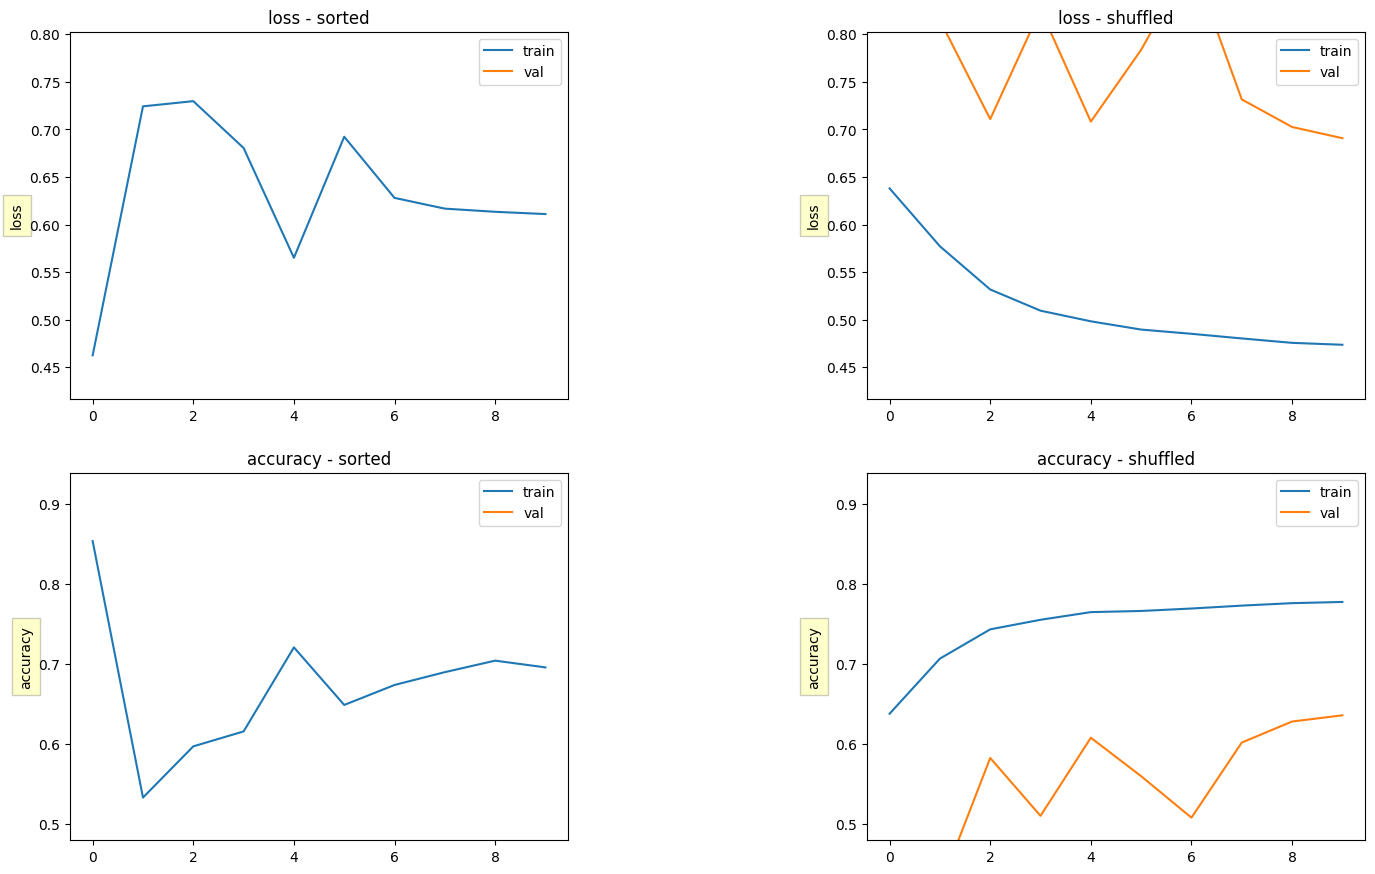

In [79]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          dan_sorted_history,
          dan_shuffled_history,
          model_1_name='sorted',
         model_2_name='shuffled')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

### 1.3 Approaches for Training of Embeddings

Rerun the DAN Model in 3 separate configurations:


a.   embedding_initializer = 'word2vec' and retrain_embeddings=False

b.   embedding_initializer = 'word2vec' and retrain_embeddings=True

c.   embedding_initializer = 'uniform' and retrain_embeddings=True


**NOTE:** Train the model with static embeddings for 10 epochs and the ones with trainable embeddings for 3 epochs each. Make sure you are using the original training data we created and not the sorted data.

What do you observe about the effects of initializing and retraining the embedding matrix?

**ANSWER:**
1. Shuffling is important
2. Retrain with fine-tuning boost performace for both initialization method, convergence is much faster, but it's risking early overfitting
3. Initializing with word2vec leverages rich sementic knowledge from large pre-trained corpus provids a good starting point




**QUESTION:**

1.3.a First, what is the final validation accuracy that you just observed for the static model initialized with the word2vec after 10 epochs?  (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)

In [ ]:
#1.3.a
# stratified train/val split to avoid class-imbalance issues
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    train_input_ids, train_input_labels, test_size=0.2, stratify=train_input_labels, random_state=42
)

# 1.3.a  Static word2vec embeddings for 10 epochs
dan_w2v_static = create_dan_model(
    retrain_embeddings=False, # Set retrain_embeddings to False for static embedding
    embedding_initializer='word2vec'
)
dan_w2v_static_history = dan_w2v_static.fit(
    X_tr, y_tr,
    epochs=10,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6437 - loss: 0.6499 - val_accuracy: 0.7097 - val_loss: 0.5990
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7186 - loss: 0.5682 - val_accuracy: 0.7377 - val_loss: 0.5381
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7393 - loss: 0.5304 - val_accuracy: 0.7475 - val_loss: 0.5186
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7493 - loss: 0.5149 - val_accuracy: 0.7533 - val_loss: 0.5098
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7599 - loss: 0.5055 - val_accuracy: 0.7623 - val_loss: 0.5001
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7564 - loss: 0.5000 - val_accuracy: 0.7623 - val_loss: 0.4955
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7603 - loss: 0.4933 - val_accuracy: 0.7628 - val_loss: 0.4899
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7632 - loss: 0.4899 - val_accuracy: 0.

In [80]:
# Print the final validation accuracy (last epoch)
dan_w2v_static_acc = dan_w2v_static_history.history['val_accuracy'][-1]
print("Final val accuracy (word2vec, static, 10 epochs):", dan_w2v_static_acc)

Final val accuracy (word2vec, static, 10 epochs): 0.7570000290870667


**QUESTION:**


1.3.b What is the final validation accuracy that you observed for the model where you initialized with word2vec vectors but allow them to retrain for 3 epochs? (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)



In [81]:
#1.3.b
# 1.3.b: word2vec init + retrain embeddings, train 3 epochs
dan_w2v_finetune = create_dan_model(
    retrain_embeddings=True, # Set retrain_embeddings to True for fine-tuning
    embedding_initializer='word2vec'
)

hist_w2v_finetune = dan_w2v_finetune.fit(
    X_tr, y_tr,
    epochs=3,
    batch_size=32,
    shuffle=True,                 # normal training
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7197 - loss: 0.5387 - val_accuracy: 0.7968 - val_loss: 0.4378
Epoch 2/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8499 - loss: 0.3493 - val_accuracy: 0.8035 - val_loss: 0.4376
Epoch 3/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8949 - loss: 0.2587 - val_accuracy: 0.7930 - val_loss: 0.4804


In [82]:
dan_w2v_finetune_acc = hist_w2v_finetune.history['val_accuracy'][-1]
print("Final val accuracy (word2vec, fine-tune, 3 epochs):", dan_w2v_finetune_acc)

Final val accuracy (word2vec, fine-tune, 3 epochs): 0.7929999828338623


**QUESTION:**

1.3.c What is the final validation accuracy that you observed for the model where you initialized randomly and then trained?  (Copy and paste the decimal value for the final validation accuracy, e.g. a number like 0.5678 or 0.8765)




In [87]:
#1.3.c
# 1.3.c: uniform init + retrain embeddings, train 3 epochs
dan_uniform_finetune = create_dan_model(
    retrain_embeddings=True, # Set retrain_embeddings to True for fine-tuning
    embedding_initializer='uniform' # Use uniform initialization
)
hist_uniform_finetune = dan_uniform_finetune.fit(
    X_tr, y_tr,
    epochs=3,
    batch_size=32,
    shuffle=True,                 # normal training
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/3


500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7155 - loss: 0.5433 - val_accuracy: 0.8010 - val_loss: 0.4372
Epoch 2/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8502 - loss: 0.3492 - val_accuracy: 0.8000 - val_loss: 0.4424
Epoch 3/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8961 - loss: 0.2603 - val_accuracy: 0.7820 - val_loss: 0.5089


In [88]:
dan_uniform_finetune_acc = hist_uniform_finetune.history['val_accuracy'][-1]
print("Final val accuracy (uniform, fine-tune, 3 epochs):", dan_uniform_finetune_acc)

Final val accuracy (uniform, fine-tune, 3 epochs): 0.7820000052452087
